# **Stable Diffusion** 🎨 
*...using `🧨diffusers`*

Stable Diffusion es un modelo de difusión latente de texto a imagen creado por investigadores e ingenieros de [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) y [LAION](https://laion.ai/). Está entrenado en imágenes de 512x512 de un subconjunto del dataset [LAION-5B](https://laion.ai/blog/laion-5b/). Este modelo utiliza un codificador de texto CLIP ViT-L/14 congelado para condicionar el modelo en las indicaciones de texto. Con su codificador de texto 860M UNet y 123M, el modelo es relativamente liviano y se ejecuta en una GPU con al menos 10 GB de VRAM.
Ver la [model card](https://huggingface.co/CompVis/stable-diffusion) para mas informacion.
Este notebook de Colab muestra cómo usar Stable Diffusion con la libreria de 🤗 Hugging Face [🧨 Diffusers](https://github.com/huggingface/diffusers). 

¡Empecemos!

## 1. Cómo utilizar `StableDiffusionPipeline`

Antes de sumergirnos en los aspectos teóricos de cómo funciona  Stable Diffusion,
probemos un poco 🤗.

En esta sección, mostramos cómo puede ejecutar la inferencia de texto a imagen en solo unas pocas líneas de código.

### Configuración

Primero, hay que asegurarse de estar usando un entorno de ejecución GPU para ejecutar este notebook, de modo que la inferencia sea mucho más rápida. Si el siguiente comando falla, use el menú `entorno de ejecución` del menu y seleccione `Cambiar tipo de entorno ejecución`.

Chequeamos la tarjeta gráfica 

In [ ]:
!nvidia-smi

Fri Nov 18 20:24:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Ahora tenemos que instalar los paquetes necesarios: `diffusers==0.4.0`, `scipy`, `ftfy` y `transformers`.

In [ ]:
!pip install diffusers==0.4.0
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 229 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 69.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 7.6 MB 49.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


Para usar el traductor de español a inglés a demas debemos instalar `sentencepiece` y `sacremoses`. Una vez instalado reiniciar el entorno de ejecución y continuar cargando las celdas hacia abajo

In [ ]:
!pip install sentencepiece
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 5.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=1067260efd0e7611c51ab80c3025ca2ecc95dc43ab2715e5fb82e7ed19aba248
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


También se debe aceptar la licencia del modelo antes de descargarlo o usarlo. En esta publicación, usaremos la versión del modelo `v1-4`, por lo que hay que ir a [la pagina](https://huggingface.co/CompVis/stable-diffusion-v1-4) leer la licencia y marcar la casilla de verificación si está de acuerdo.

Tienes que ser un usuario registrado en 🤗 Hugging Face Hub, y también necesitarás usar un token de acceso para que el código funcione. Para obtener más información sobre los tokens de acceso, consulte [esta sección de la documentación](https://huggingface.co/docs/hub/security-tokens).

Creamos un token para esta aplicacion, le damos el nombre que deseamos para identificarlo y luego lo copiamos para usarlo mas abajo cuando sea necesario autentificar

Como google colab ha deshabilitado los widgets externos, debemos habilitarlo explícitamente. Ejecute la siguiente celda para poder usar

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Tambien podemos habilitar, si deseamos, la conexion de google colab con nustro drive. Esto nos servira para ir dejando aqui guardadas las imagenes que generemos. Tenemos que habilitar el permiso en las ventanas emergentes

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Ahora iniciamos sesión con su token de usuario de 🤗

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


### Stable Diffusion Pipeline

`StableDiffusionPipeline` es una end-to-end inference pipeline que puede usar para generar imágenes a partir de texto con solo unas pocas líneas de código.

En primer lugar, cargamos los pesos preentrenados de todos los componentes del modelo.

Además de la identificación del modelo [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4). Tambien pasaremos una especifica  `revision` y `torch_dtype` al metodo `from_pretrained`.

Asegurarse de haber iniciado sesión correctamente para que se pueda verificar que efectivamente ha aceptado la licencia del modelo.

Para que cada Google Colab gratuito pueda ejecutar Stable Diffusion,  cargamos los pesos de la half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) y tambien le decimos a `diffusers` que espere pesos con precisión float16 pasando `torch_dtype=torch.float16`.

Si desea garantizar la mayor precisión posible, asegúrese de eliminar `revision="fp16"` y `torch_dtype=torch.float16` a costa de un mayor uso de memoria.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# asegúrese de haber iniciado sesión con `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)  

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

A continuación, movamos el pipeline a GPU para tener una inferencia más rápida.

In [ ]:
pipe = pipe.to("cuda")

Como necesitamos los prompts en ingles vamos a hacer uso de un traductor, tambien importado de la libreria Transformers 🤗

In [ ]:
from transformers import pipeline

spanish_model_name = "Helsinki-NLP/opus-mt-es-en"
translator_es_en = pipeline("translation", model=spanish_model_name)


Downloading:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

In [ ]:
text = 'un dibujo del perro fuerte y el perro debil'
english_text = translator_es_en(text)
result_en = english_text[0]['translation_text']
result_en

'a drawing of the strong dog and the weak dog'

El uso de `autocast` ejecutará la inferencia más rápido porque usa la mitad de precisión.

  0%|          | 0/51 [00:00<?, ?it/s]

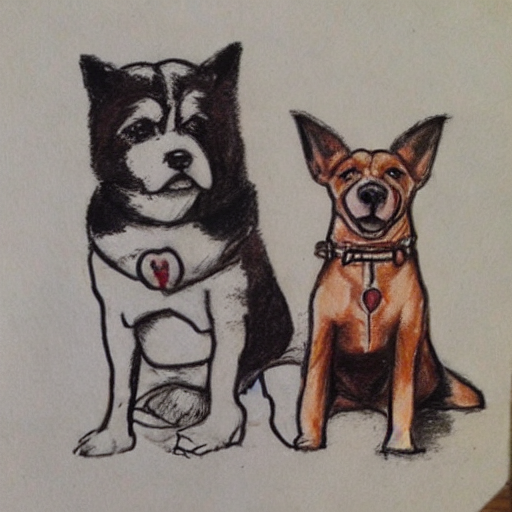

In [ ]:
prompt = text
image = pipe(prompt).images[0]  # la imagen aquí está en [PIL format](https://pillow.readthedocs.io/en/stable/)

# Visualizamos la imagen. En el proximo cuadro de codigo podemos guardarla
image

En este paso Creamos una carpeta llamada "imagenes" donde guardaremos los outputs. Si conectamos con drive le damos el path a la carpeta donde queremos almacenar las imagenes. De lo contrario podemos crear una carpeta temporal donde vamos guardando las imagenes pero recordar que cuando el entorno de ejecucion se desconecte perderemos todo lo guardado

In [ ]:
import os
folder_path = '/content/gdrive/MyDrive/imagenes' # agregar el path al drive donde quieres que se genere la carpeta "imagenes"
os.makedirs(folder_path, exist_ok=True)


Este numero es para que no se sobreescriban las imagenes si tienen el mismo nombre. Se da que muchas veces corremos varias veces el mismo prompt y queremos guardar las diferentes imagenes que se generan. si no le agregamos un numero al final al path sobreescribira las imagenes.

In [ ]:
# Correr este bloque una sola vez o cada vez que cambiemos el prompt
i = 0

Finalmente guardamos la imagen generada.

In [ ]:
# La guardamos
image.save('{}/{}_{}.png'.format(folder_path,text,i))
i+=1